In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install transformers

In [ ]:
!pip install indic-transliteration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.2/146.2 kB 2.7 MB/s eta 0:00:00


In [ ]:
#importing all necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

from sklearn.preprocessing import LabelEncoder
from itertools import chain # for flatting the list
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


from transformers import BertModel
from transformers import BertTokenizer
from transformers import AutoModel, AutoTokenizer


from indic_transliteration import sanscript
from indic_transliteration.sanscript import SchemeMap, SCHEMES, transliterate

import re
import unicodedata
import codecs
import random

In [ ]:
# for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [ ]:
random.random()

0.15427731045476323

In [ ]:
#dataset classs for ATIS data
class ATIS(Dataset):

  def __init__(self, file_name, translit_prob=0, shuffle_prob=0, max_token_len=100):
    super(ATIS, self).__init__()

    self.df = pd.read_csv(file_name, header=None)
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
    self.max_token_len = max_token_len
    self.translit_prob = translit_prob
    self.shuffle_prob = shuffle_prob

    self.label_encoder = LabelEncoder().fit(list(self.df[0]))


  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):

    query = self.df.iloc[index, 1]
    query = self.query_preprocessing(query)

    if random.random() < self.shuffle_prob:
      query_list = query.split()
      if len(query_list) < 10:
        random.shuffle(query_list)
        query = " ".join(query_list)



    label = self.label_encoder.transform([self.df.iloc[index, 0]])

    # print(query)
    # print(label)

    tokens = self.tokenizer.tokenize(query)
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    if len(tokens) < self.max_token_len:
      tokens = tokens + ['[PAD]' for i in range(self.max_token_len-len(tokens))]
    else:
      tokens = tokens[:self.max_token_len-1] + ['[SEP]']

    token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

    token_id_tensor = torch.tensor(token_ids)
    label_tensor = torch.tensor(label)
    attention_mask_tensor = (token_id_tensor != 0).long()

    return token_id_tensor, attention_mask_tensor, label_tensor

  def unicodeToAscii(self, s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

  def normalizeString(self, s):
    s = self.unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s


  def query_preprocessing(self, query_text):
    q= self.normalizeString(query_text)

    return q

In [ ]:
train_file = 'tamil_train.csv'
test_file = 'tamil_dev.csv'

In [ ]:
# creating instance of datset class
train_set = ATIS(file_name = train_file, max_token_len=120, translit_prob=0.5, shuffle_prob=0)
test_set = ATIS(file_name = test_file, max_token_len=120, translit_prob=0, shuffle_prob=0)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
print(len(train_set))
print(len(test_set))

9075
1022


In [ ]:
train_set[6]

(tensor([  101, 59287, 10112, 26584, 10211, 11901, 39272, 10116, 24603, 18542,
         10544, 12721, 10747,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
train_loader = DataLoader(train_set, batch_size = 64, num_workers = 4, shuffle=True)
val_loader = DataLoader(test_set, batch_size = 64, num_workers =4, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
for i, data in enumerate(train_loader, 0):
  print(data[0].shape)
  print(data[1].shape)
  print(data[2].shape)
  break

torch.Size([64, 120])
torch.Size([64, 120])
torch.Size([64, 1])


In [ ]:
class INTENT_CLASSIFIER(nn.Module):

  def __init__(self, freeze_bert=True):
    super(INTENT_CLASSIFIER, self).__init__()

    self.bert_layers = BertModel.from_pretrained('bert-base-multilingual-uncased',return_dict=False)
    self.linear1 = nn.Linear(768, 300)
    self.linear11 = nn.Linear(300, 8)
    self.linear2 = nn.Linear(8, 2)
    self.dropout = nn.Dropout(0.5)

    if freeze_bert:
      for param in self.bert_layers.parameters():
        param.requires_grad = False


  def forward(self, token_ids, atten_mask):
    """Both argument are of shape: batch_size, max_seq_len"""
    _, CLS = self.bert_layers(token_ids, attention_mask = atten_mask)
    logits = self.dropout(self.linear1(CLS))
    logits = self.dropout(self.linear11(logits))
    logits = self.linear2(logits)

    return logits

In [ ]:
model = INTENT_CLASSIFIER(freeze_bert=True)

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

In [ ]:
#len(model.bert_layers.encoder)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
class_weights = torch.tensor([5.0, 1.0]).to(device)    ## for weighted cross entropy

In [ ]:
# optimizer and loss function
criterion = nn.CrossEntropyLoss(weight=class_weights) #weight=class_weights
optimizer = torch.optim.Adam(model.parameters(), lr=1E-5, weight_decay =0.0001)
scheduler = MultiStepLR(optimizer, milestones=[26, 65, 75, 85, 95, 105, 115], gamma=0.8)

In [ ]:
model.to(device)
print(f"model loaded to {device}")

model loaded to cpu


In [ ]:
# Getting the train accuracy
def train_acc():
  correct = 0
  total = 0
  model.eval()
  y_train_prediction = []
  y_train_true = []
  with torch.no_grad():
      for data in train_loader:
          tokens, masks, labels = data

          tokens = tokens.to(device)
          masks = masks.to(device)
          labels = labels.to(device)

          outputs = model(tokens, masks)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels.squeeze()).sum().item()

          y_train_true += labels.squeeze().detach().cpu().numpy().tolist()
          y_train_prediction += predicted.detach().cpu().numpy().tolist()

  print('Train Accuracy: {}%'.format(100*correct/total))
  return y_train_true, y_train_prediction

In [ ]:
# Getting the test accuracy
def test():
  correct = 0
  total = 0
  model.eval()
  y_test_prediction = []
  y_test_true = []

  with torch.no_grad():
      for data in val_loader:
          tokens, masks, labels = data

          tokens = tokens.to(device)
          masks = masks.to(device)
          labels = labels.to(device)

          outputs = model(tokens, masks)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels.squeeze()).sum().item()

          y_test_true += labels.squeeze().detach().cpu().numpy().tolist()
          y_test_prediction += predicted.detach().cpu().numpy().tolist()

  print('Test Accuracy: {}%'.format(100 * correct / total))
  test_accuracy_value = correct/total
  return y_test_true, y_test_prediction, test_accuracy_value

In [ ]:
for param in model.bert_layers.parameters():
  param.requires_grad = False

In [ ]:
# training funciton
def train(epochs):
  best_accuracy = 0.0
  loss_list= []
  for epoch in range(1, epochs+1):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, masks, labels]
          #print(data)
          inputs, masks,  labels = data

          inputs = inputs.to(device)
          masks = masks.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs, masks)
          loss = criterion(outputs, labels.squeeze())
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 5 == 4:    # print every 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch, i + 1, running_loss / 5))
              loss_list.append(running_loss/5)
              running_loss = 0.0

      if (epoch == 5): # gradual unfreezing of Bert pameters
        print("Unfrezing layer number {}+++++++++++++++++++++++++++")
        # making last layers unfreeze
        for param in model.bert_layers.parameters():
          param.requires_grad = True

      _,_, test_accuracy_value = test()

      if test_accuracy_value > best_accuracy:
        torch.save(model, './best_model.pth')
        best_accuracy = test_accuracy_value
        print("Model Improved..... New model saved...")
      else:
        print("No improvement on previous model...")

      #_ = train_acc()
      scheduler.step()

  print('Finished Training')
  return loss_list

In [ ]:
loss_list = train(epochs=20)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[1,     5] loss: 0.699


KeyboardInterrupt: ignored

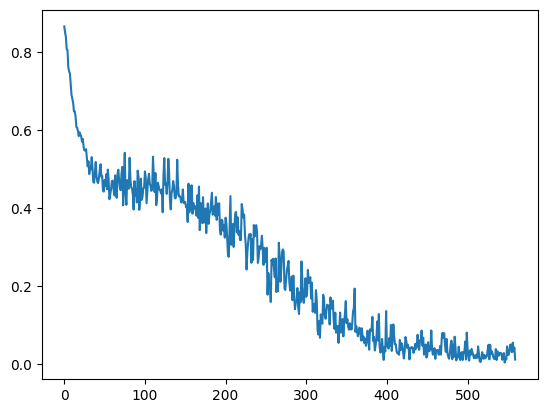

In [ ]:
plt.plot(loss_list)

In [ ]:
#loading the model
model = torch.load('./best_model.pth')

In [ ]:
y_test_true, y_test_prediction, _ = test()
#y_train_true, y_train_prediction= train_acc()

Test Accuracy: 84.54011741682974%


In [ ]:
test_set.label_encoder.inverse_transform([0, 1])

array(['Negative', 'Positive'], dtype='<U8')

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report

In [ ]:
target_names = ['Negative ', 'Positive']

In [ ]:
print("Test Accuracy", accuracy_score(y_test_true, y_test_prediction))
#print("Train Accuracy", accuracy_score(y_train_true, y_train_prediction))
print("Test Kappa Score", cohen_kappa_score(y_test_true, y_test_prediction))
#print("Train Kappa Score", cohen_kappa_score(y_train_true, y_train_prediction))

Test Accuracy 0.8454011741682974
Test Kappa Score 0.2134862108267659


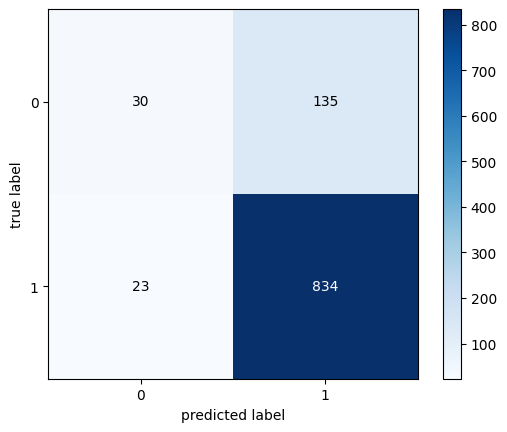

In [ ]:
multiclass = confusion_matrix(y_test_true, y_test_prediction)

class_names = target_names

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False)
plt.show()

In [ ]:
#without transliteration data augmentation
print(classification_report(y_test_true, y_test_prediction))

              precision    recall  f1-score   support

           0       0.57      0.18      0.28       165
           1       0.86      0.97      0.91       857

    accuracy                           0.85      1022
   macro avg       0.71      0.58      0.59      1022
weighted avg       0.81      0.85      0.81      1022



In [ ]:
# with tranliteration data augmentation
print(classification_report(y_test_true, y_test_prediction))

              precision    recall  f1-score   support

           0       0.57      0.18      0.28       165
           1       0.86      0.97      0.91       857

    accuracy                           0.85      1022
   macro avg       0.71      0.58      0.59      1022
weighted avg       0.81      0.85      0.81      1022

